# TSIA201 TP2 : Practical works on Filter Banks

**Practical work done by : IQBI Hamza**


In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import time
import pyaudio

### 1.Two channel Filter Bank :

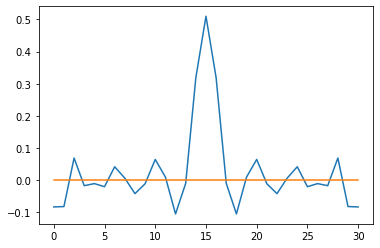

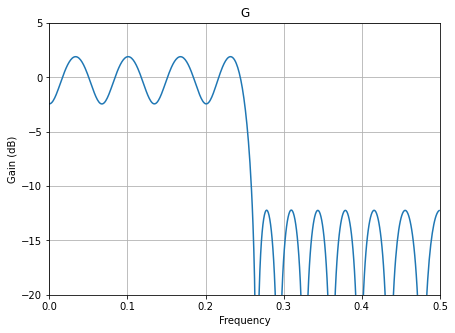

In [94]:
########## Q1

#----- Synthesising a low-pass filter of type 1 directly using the scipy.remez method -----#
'''There is an error in the practical work'''


def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(7)   
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    #ax.plot(w, h)
    ax.set_ylim(-20, 5)
    ax.set_xlim(0, fs/2)
    ax.grid(True)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)
    
fs = 1
epsilon = 0.01*fs
cutoff = fs/4
transwidth = epsilon/2
N=16
numtaps = 2*N-1
g = signal.remez(numtaps, [0, cutoff, cutoff+epsilon, 0.5], [1, 0], Hz=fs)
nu, G = signal.freqz(g, [1])
plt.plot(np.arange(numtaps), g)
plt.plot(np.arange(numtaps), np.zeros(numtaps))
plot_response(fs, nu, G, "G")
#G = [V[2*nu] for nu in range(len(V)//2)]
#plot_response(1, W[0:len(W)//2], G, "G")

[ 0.         -0.08248795  0.         -0.01751693  0.         -0.0206751
  0.          0.00595708  0.         -0.01152567  0.          0.0093827
  0.         -0.01031128  0.          0.50982093  0.         -0.01031128
  0.          0.0093827   0.         -0.01152567  0.          0.00595708
  0.         -0.0206751   0.         -0.01751693  0.         -0.08248795
 -0.08366915]


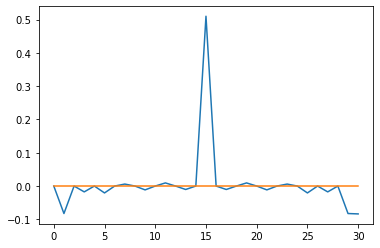

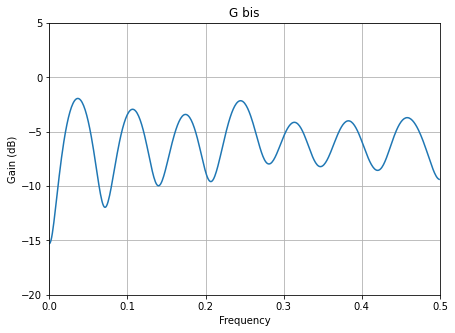

In [95]:
########## Q2

#----- Manually zeroing the coefficients which should be zero -----#

for k in range(0, len(g)//2) :
    g[2*k] = 0
print(g)
plt.plot(np.arange(numtaps), g)
plt.plot(np.arange(numtaps), np.zeros(numtaps))
w, G_bis = signal.freqz(g, [1])
plot_response(fs, w, G_bis, "G bis")

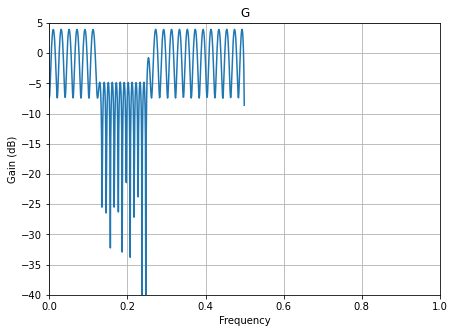

In [69]:
## for Q3
fs = 1
band = [fs/8, fs/4]
transwidth = 1/500
numtaps = 100
edges = [0, band[0]-transwidth, band[0], band[1], band[1]+transwidth, fs/2]
g = signal.remez(numtaps, edges, [1, 0, 1], Hz=fs)
nu, G = signal.freqz(g, [1])
plot_response(fs, nu, G, "G")